In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv('Churn Model.csv')

In [28]:
df.head()

,merchant_id,total_transactions,total_volume_processed,avg_transaction_amount,successful_transaction_rate,failure_rate,days_since_last_transaction,txns_last_30d,txns_prev_30d,volume_last_30d,volume_prev_30d,volume_change_pct_30d,num_payment_methods_used,merchant_age_days,business_type,churn_flag
0,m_000f075d63,10,494575.0,49457.500000,1.000000,0.000000,102,0,0,0.0,0.0,NaN,3,119,Enterprise,1
1,m_01b846e000,15,656846.0,43789.733333,1.000000,0.000000,92,0,0,0.0,0.0,NaN,3,141,SME,1
2,m_01e9a0b208,29,1093271.0,37699.000000,1.000000,0.000000,73,0,0,0.0,0.0,NaN,3,169,Enterprise,1
3,m_02f4599a40,245,9481635.0,38914.073469,0.995918,0.004081,0,68,61,2868089.0,2102762.0,0.363962,3,172,SME,0
4,m_03a6e19aa3,7,342019.0,48859.857142,1.000000,0.000000,107,0,0,0.0,0.0,NaN,3,135,SME,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_id                  340 non-null    object 
 1   total_transactions           340 non-null    int64  
 2   total_volume_processed       340 non-null    float64
 3   avg_transaction_amount       340 non-null    float64
 4   successful_transaction_rate  340 non-null    float64
 5   failure_rate                 340 non-null    float64
 6   days_since_last_transaction  340 non-null    int64  
 7   txns_last_30d                340 non-null    int64  
 8   txns_prev_30d                340 non-null    int64  
 9   volume_last_30d              340 non-null    float64
 10  volume_prev_30d              340 non-null    float64
 11  volume_change_pct_30d        106 non-null    float64
 12  num_payment_methods_used     340 non-null    int64  
 13  merchant_age_days   

In [31]:
df['churn_flag'].value_counts()

churn_flag
1    308
0     32
Name: count, dtype: int64

In [32]:
X = df.drop(['merchant_id', 'volume_change_pct_30d', 'churn_flag'], axis=1)
y = df['churn_flag']

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [36]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),                  
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [40]:
from sklearn.pipeline import Pipeline

In [41]:
rfc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rfc)
])

In [42]:
rfc_pipeline.fit(X_train, y_train)
rfc_pred = rfc_pipeline.predict(X_test)
rfc_pred_proba = rfc_pipeline.predict_proba(X_test)[:, 1]

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [44]:
print("RANDOM FOREST RESULTS")
print(f"Accuracy: {accuracy_score(y_test, rfc_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, rfc_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rfc_pred, target_names=['Yes', 'No']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rfc_pred))

RANDOM FOREST RESULTS
Accuracy: 0.9608
ROC-AUC Score: 0.9967

Classification Report:
              precision    recall  f1-score   support

         Yes       0.75      0.90      0.82        10
          No       0.99      0.97      0.98        92

    accuracy                           0.96       102
   macro avg       0.87      0.93      0.90       102
weighted avg       0.97      0.96      0.96       102


Confusion Matrix:
[[ 9  1]
 [ 3 89]]


In [51]:
rf_model = rfc_pipeline.named_steps['classifier']

In [52]:
num_features = num_cols.tolist()

cat_features = (
    rfc_pipeline
    .named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(cat_cols)
)


all_feature_names = num_features + list(cat_features)

In [53]:
feature_importance_rf = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_rf.head(10))

                        feature  importance
5   days_since_last_transaction    0.256862
8               volume_last_30d    0.233699
6                 txns_last_30d    0.187011
7                 txns_prev_30d    0.111009
9               volume_prev_30d    0.078309
0            total_transactions    0.067091
1        total_volume_processed    0.048688
2        avg_transaction_amount    0.006566
11            merchant_age_days    0.004898
13            business_type_SME    0.002877


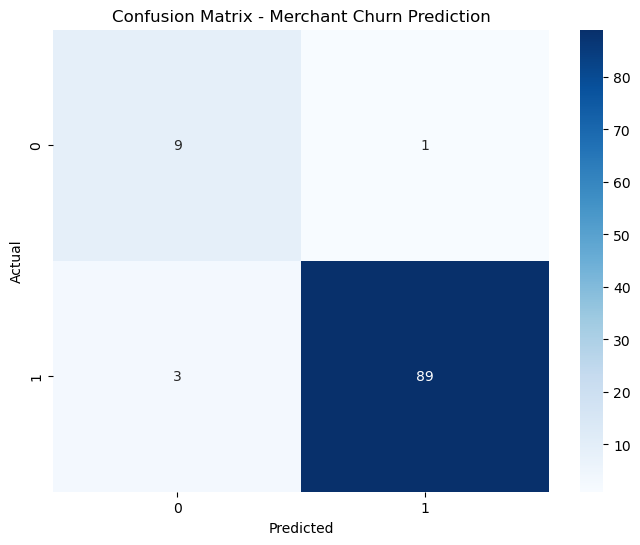

In [55]:
cm = confusion_matrix(y_test, rfc_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Merchant Churn Prediction')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix_churn.png')
plt.show()

In [56]:
import joblib

In [57]:
joblib.dump(rfc_pipeline, 'rf=rfc_pipeline.pkl')

['rf=rfc_pipeline.pkl']

In [59]:
feature_importance_rf.to_csv('feature_importance.csv', index=False)

In [61]:
all_pred_proba = rfc_pipeline.predict_proba(X)[:, 1]
df['churn_probability'] = all_pred_proba

In [66]:
def risk_category(prob):
    if prob >= 0.66:
        return 'High Risk'
    elif prob >= 0.33:
        return 'Medium Risk'
    else:
        return 'Low Risk'
df["Churn_Risk_Level"] = df['churn_probability'].apply(risk_category)

In [72]:
df["Churn_Risk_Level"].value_counts()

Churn_Risk_Level
High Risk      297
Low Risk        32
Medium Risk     11
Name: count, dtype: int64

In [71]:
df.to_csv("churn_predictions_with_risk.csv", index=False)

In [74]:
df.sort_values("churn_probability", ascending=False).head(20)

,merchant_id,total_transactions,total_volume_processed,avg_transaction_amount,successful_transaction_rate,failure_rate,days_since_last_transaction,txns_last_30d,txns_prev_30d,volume_last_30d,volume_prev_30d,volume_change_pct_30d,num_payment_methods_used,merchant_age_days,business_type,churn_flag,churn_probability,Churn_Risk_Level
0,m_000f075d63,10,494575.0,49457.500000,1.000000,0.000000,102,0,0,0.0,0.0,NaN,3,119,Enterprise,1,1.0,High Risk
215,m_9d43863046,1,37175.0,37175.000000,1.000000,0.000000,141,0,0,0.0,0.0,NaN,1,154,Enterprise,1,1.0,High Risk
190,m_8a19a2f57a,17,585950.0,34467.647058,1.000000,0.000000,87,0,0,0.0,0.0,NaN,3,162,Enterprise,1,1.0,High Risk
192,m_8da4c18fe0,26,1284952.0,49421.230769,1.000000,0.000000,106,0,0,0.0,0.0,NaN,3,139,Enterprise,1,1.0,High Risk
193,m_8dfaae8206,7,353524.0,50503.428571,1.000000,0.000000,103,0,0,0.0,0.0,NaN,3,141,SME,1,1.0,High Risk
194,m_8e03759679,7,298082.0,42583.142857,1.000000,0.000000,106,0,0,0.0,0.0,NaN,3,130,Enterprise,1,1.0,High Risk
195,m_8e72acadfe,5,225340.0,45068.000000,1.000000,0.000000,113,0,0,0.0,0.0,NaN,3,131,SME,1,1.0,High Risk
196,m_8ea0fd18f2,31,1204386.0,38851.161290,1.000000,0.000000,59,0,1,0.0,54598.0,-1.0,3,129,SME,1,1.0,High Risk
197,m_8f52ee4bb0,12,330072.0,27506.000000,1.000000,0.000000,102,0,0,0.0,0.0,NaN,3,142,SME,1,1.0,High Risk
198,m_8f8863c047,6,266299.0,44383.166666,1.000000,0.000000,117,0,0,0.0,0.0,NaN,3,156,Enterprise,1,1.0,High Risk


In [77]:
!jupyter nbconvert --to python Churn_Prediction.ipynb

[NbConvertApp] Converting notebook Churn_Prediction.ipynb to python
[NbConvertApp] Writing 3621 bytes to Churn_Prediction.py
